# Classificação de Imagens de 38 classes de plantas por tipos de doenças, com 

Transfer Learning
#### Objetivo: Analisar algumas redes com transfer learning e comparar os resultados, com base na variação de ajustes relacionados a parâmetros de early stop, early rate, camada dropout, camada BatchNormalize e Batchsize.
#### Após análises dos dados de cada uma das 38 classes de imagens e por questão de performance, na execução limitada de processamento, a opção foi por utilizar somente 04 classes de status das condições de folhas de Uva, sendo que uma delas não continha imagens, sendo assim essa descartada.


##### Classes Consideradas:
###### Grape___Black_rot
###### Grape___Esca_(Black_Measles)
###### Grape___healthy


## Legenda:
#### Localização da base de dados no Kaggle: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
#### Base de dados de treino (trainpath): Já separada pelo autor da base de dados, em localização específica no Kaggle.
#### base de dados de validação (validpath): Já separada pelo autor da base de dados, em localização específica no Kaggle. 
## Consultas:
##### https://keras.io/applications/
##### https://www.tensorflow.org/tutorials/load_data/images
##### https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
##### https://keras.io/api/data_loading/

## Leitura do local da base de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

Mounted at /content/drive


In [ ]:
os.path.abspath(os.getcwd())

'/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive'

In [ ]:
# Base de imagens para treino com total de 4659 imagens (classes de tipos de platas)
trainpath = workdir_path + '/classeuva/Train'

# Base de imagens para validação com total 1169 imagens (classes de tipos de platas)
validpath = workdir_path + '/classeuva/Valid'

# Base de imagens para validação com total de 30 imagens (classes de tipos de platas)
testpath = workdir_path + '/classeuva/Test'


## Leitura de Bibliotecas

In [ ]:
!pip install keras_tqdm
!pip install tf-explain
import numpy as np
import keras as ks
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions 
%matplotlib inline
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, Model,load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
import os
import tensorflow_datasets as tfds
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from PIL import Image
# from keras.preprocessing.image import array_to_img, img_to_array, load_img
# from keras.applications.vgg16 import preprocess_input
from keras import losses
from tensorflow.keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from random import randint
import matplotlib.pylab as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 3.9 MB/s eta 0:00:00


## Contagem das classes de treino

In [ ]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta

count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(trainpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(trainpath+"/"+i)
  totalimagens.append(len(images_path))


In [ ]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Contagem das classes de validação

In [ ]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta

count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(validpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(trainpath+"/"+i)
  totalimagens.append(len(images_path))


In [ ]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Tratar e  Carregar a Base de Treino
##### Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
##### A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imágens
batch_size = 32
# altura da imagem
img_height = 299
# largura da imagem
img_width = 299

In [ ]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de treino
  trainpath,                                                # caminho onde estão as imagens de treino (diretório "raiz")
  labels='inferred',                                        
  label_mode='categorical',                                             
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote


Found 4659 files belonging to 3 classes.


In [ ]:
# verifica o nome das classes (são 38 pastas, cada pasta é uma classe)
train_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [ ]:
# visualizar o tipo de objeto retornado
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# loop para ver a dimensão da imagem:
# 32 classes (pastas)
# 299 largura
# 299 altura
# 3 canais
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  break

(32, 299, 299, 3)


In [ ]:
# Normalizar as imagens de treino para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data_normalized = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 0.8826677


In [ ]:
# Analisa o resultado da normalização da Base de Treino
for image_batch, labels_batch in train_data_normalized:
  print(image_batch.shape)
  break

(32, 299, 299, 3)


In [ ]:
# Analisa o resultado da normalização da Base de Treino - Formato
train_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# Analisa o resultado da normalização da Base de Treino - Matriz EGB
image_batch[5]

<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[0.5372549 , 0.5058824 , 0.49803925],
        [0.5003476 , 0.46897504, 0.4611319 ],
        [0.5655453 , 0.5341728 , 0.52632964],
        ...,
        [0.72469664, 0.70901036, 0.71293193],
        [0.7287956 , 0.7131093 , 0.7170309 ],
        [0.69803923, 0.68235296, 0.6862745 ]],

       [[0.5464818 , 0.51510924, 0.5072661 ],
        [0.53852016, 0.5071476 , 0.49930447],
        [0.5447052 , 0.51333266, 0.5054895 ],
        ...,
        [0.70513725, 0.689451  , 0.69337255],
        [0.7085932 , 0.6929069 , 0.6968285 ],
        [0.68266124, 0.66697496, 0.67089653]],

       [[0.6118106 , 0.5804381 , 0.57259494],
        [0.5881726 , 0.55680007, 0.54895693],
        [0.586102  , 0.55472946, 0.5468863 ],
        ...,
        [0.68951344, 0.6738272 , 0.67774874],
        [0.69121736, 0.6755311 , 0.67945266],
        [0.6784314 , 0.6627451 , 0.6666667 ]],

       ...,

       [[0.5976656 , 0.56629306, 0.55452836],
        [0.56

## Tratar e  Carregar a Base de Validação
## Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
## A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imagens
batch_size = 32
# altura da imagem
img_height = 299
# largura da imagem
img_width = 299

In [ ]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

valid_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de validação
  validpath,                                                # caminho onde estão as imagens de validação (diretório "raiz")
  labels='inferred',                                        
  label_mode='categorical',                                 
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote

Found 1169 files belonging to 3 classes.


In [ ]:
# verifica o nome das classes (são 38 pastas, cada pasta é uma classe)
valid_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [ ]:
# visualizar o tipo de objeto retornado
valid_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# loop para ver a dimensão da imagem:
# 32 classes (pastas)
# 299 largura
# 299 altura
# 3 canais
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in valid_data:
  print(image_batch.shape)
  break

(32, 299, 299, 3)


In [ ]:
# Normalizar as imagens de validação para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
valid_data_normalized = valid_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(valid_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.8479688


In [ ]:
# Analisa o resultado da normalização da Base de Validação
for image_batch, labels_batch in valid_data_normalized:
  print(image_batch.shape)
  break

(32, 299, 299, 3)


In [ ]:
# Analisa o resultado da normalização da Base de Validação - Formato
valid_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# Analisa o resultado da normalização da Base de Validação - Matriz EGB
image_batch[2]

<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[0.7176471 , 0.68235296, 0.7019608 ],
        [0.7176471 , 0.68235296, 0.7019608 ],
        [0.74276346, 0.70746934, 0.7270772 ],
        ...,
        [0.65820724, 0.6111484 , 0.6111484 ],
        [0.6304483 , 0.58338946, 0.58338946],
        [0.58431375, 0.5372549 , 0.5372549 ]],

       [[0.72072273, 0.6854286 , 0.70503646],
        [0.7327834 , 0.69748926, 0.7170971 ],
        [0.7178809 , 0.6825868 , 0.70219463],
        ...,
        [0.6389922 , 0.59193337, 0.59193337],
        [0.6294817 , 0.58242285, 0.58242285],
        [0.535104  , 0.48804516, 0.48804516]],

       [[0.719057  , 0.6837629 , 0.70337075],
        [0.72655576, 0.69126165, 0.7108695 ],
        [0.69526136, 0.65996724, 0.6795751 ],
        ...,
        [0.6317333 , 0.5846745 , 0.5846745 ],
        [0.6093235 , 0.5622647 , 0.5622647 ],
        [0.6119877 , 0.5649289 , 0.5649289 ]],

       ...,

       [[0.69896376, 0.66366965, 0.67543435],
        [0.68

## Resumo Leitura de Imagens
##### 4659 .. 80% testes, 1169 .. validação

## Modelo de Classificação Xception sem Transfer Learning e Data Augmentation
##### Analisar a resposta da classificação

In [ ]:
## Código consultado em https://medium.com/analytics-vidhya/image-recognition-using-pre-trained-xception-model-in-5-steps-96ac858f4206

model = tf.keras.applications.xception.Xception(weights='imagenet', input_shape=(img_height,img_width,3))

# Carrega uma imagem de uma classe (Treino) para verificar a predição nessa Rede, nessas condições.
img = image.load_img(trainpath+"/Grape___healthy/ac753212-e6d7-44b9-9722-4413a7418ab3___Mt.N.V_HL 6178_180deg.JPG", target_size=(img_height,img_width,3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=4)[0])


35363/35363 [==============================] - 0s 0us/step
Predicted: [('n03991062', 'pot', 0.8326949), ('n12768682', 'buckeye', 0.020133035), ('n07716358', 'zucchini', 0.010261949), ('n12620546', 'hip', 0.0064591994)]


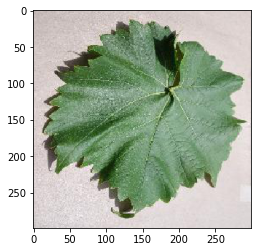

In [ ]:
# Avaliação da assertividade para a classe Tomato___Tomato_mosaic_virus da base de treino
import matplotlib.pylab as plt
plt.imshow(img)

Modelo nessa condição não obteve sucesso na identificação de uma imagem de uma classe. O que era previsto somente comprovando a necessidade de treinar um modelo aplicando Transfer Learning.

In [ ]:
# Visualização das Camadas do Modelo Xception sem Transfer Learning e Data Augmentation
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

## Analisa Camadas Xception Truncada

In [ ]:
base_model_tf=tf.keras.applications.xception.Xception(weights='imagenet', classes=3, input_shape=(img_height,img_width,3), include_top=False)

#Model building
base_model_tf.trainable=False

base_model_tf.summary()


83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
## API Keras https://keras.io/guides/functional_api/
## https://keras.io/guides/sequential_model/

## Modelo Xception Base para Aplicar Transfer Learning


In [ ]:
# Modelo Truncado:
modelo_base = tf.keras.applications.xception.Xception(weights='imagenet', classes=3, input_shape=(img_height,img_width,3), include_top=False)
# "Congelar" as camadas superiores (manter os pesos):
modelo_base.trainable=False
modelo_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

## Modelo Xception Truncado + Camada Dense

*   Aproveitar a base de conhecimento Xception (Imagenet) e seus pesos
*   Treinar essa base adicionando as novas Classes de Treino das Imagens Coletadas



In [ ]:
sh=Input(shape=(img_height,img_width,3)) # Formato de entrada imagem
conv=tf.cast(sh,tf.float32) 

modelo_dense_1=modelo_base(conv,training=False)
modelo_dense_1=Dropout(0.2)(modelo_dense_1)
modelo_dense_1=GlobalAveragePooling2D()(modelo_dense_1)
modelo_dense_1=Dense(128,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(64,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(3,activation='softmax')(modelo_dense_1)

from keras.models import Model
modelo_final_1=Model(inputs=sh,outputs=modelo_dense_1)
modelo_final_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 dropout (Dropout)           (None, 10, 10, 2048)      0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                             

In [ ]:
modelo_final_1.layers

In [ ]:
# Definie as métricas
earlystp=EarlyStopping(patience=50, monitor='val_loss') # Evitar um Overfiting do Modelo
metrics = ['accuracy',Precision(),Recall(), AUC()]

In [ ]:
# Compila o Modelo
modelo_final_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01),metrics=metrics)

In [ ]:
# Processa o modelo com Transfer Learning usando a base de imagens de Treino Normalizada e a base de Validação Normalizada
modelo_final_1_Hist = modelo_final_1.fit(train_data_normalized,validation_data=valid_data_normalized,epochs=200,verbose=1,callbacks=[earlystp])

Epoch 1/200
146/146 [==============================] - 500s 3s/step - loss: 0.2406 - accuracy: 0.9217 - precision: 0.9285 - recall: 0.9148 - auc: 0.9838 - val_loss: 0.0947 - val_accuracy: 0.9658 - val_precision: 0.9658 - val_recall: 0.9658 - val_auc: 0.9976
Epoch 2/200
146/146 [==============================] - 47s 320ms/step - loss: 0.0744 - accuracy: 0.9730 - precision: 0.9738 - recall: 0.9725 - auc: 0.9979 - val_loss: 0.0796 - val_accuracy: 0.9666 - val_precision: 0.9666 - val_recall: 0.9666 - val_auc: 0.9982
Epoch 3/200
146/146 [==============================] - 48s 327ms/step - loss: 0.0575 - accuracy: 0.9770 - precision: 0.9777 - recall: 0.9766 - auc: 0.9987 - val_loss: 0.0674 - val_accuracy: 0.9760 - val_precision: 0.9760 - val_recall: 0.9743 - val_auc: 0.9985
Epoch 4/200
146/146 [==============================] - 49s 327ms/step - loss: 0.0341 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9869 - auc: 0.9995 - val_loss: 0.0884 - val_accuracy: 0.9649 - val_precision: 0.9649 -

In [ ]:
modelo_final_1.save('/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive/Inferência-TestesModelos/Caso de Teste 01/Xception-Cenário04/Modelo_Salvo_2/Xception.h5')

## Análise da Xception - Transfer Learning
##### Métricas:
###### Acurácia: Taxa de acerto do modelo - VP + VN / (VP+VN+FN+FP). Pode mascarar falso positivo e falso negativo.
###### Recall: Taxa de VP entre todas as classes positivas. Varia de 0 a 1 , quanto maior o valor melhor - VP / VP + FN
###### Precisão: Taxa de VP entre os valores Positivos Preditos. VP / VP+FP. Quanto menor a qtd de falsos alarmes melhor.
###### AUC: Relação com a curva ROC (Receiver Operating Characteristic). É a área sob a curva e é recomendada para comparar modelos diferentes. Varia entre 0 e 1 e quanto maior o valor melhor a classificação.

In [ ]:
print(modelo_final_1_Hist.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


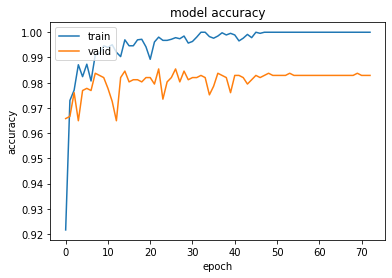

In [ ]:
plt.plot(modelo_final_1_Hist.history['accuracy'])
plt.plot(modelo_final_1_Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

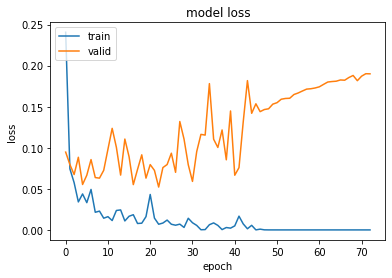

In [ ]:
plt.plot(modelo_final_1_Hist.history['loss'])
plt.plot(modelo_final_1_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

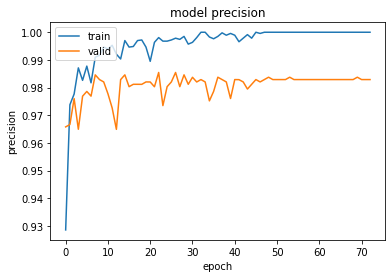

In [ ]:
plt.plot(modelo_final_1_Hist.history['precision'])
plt.plot(modelo_final_1_Hist.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

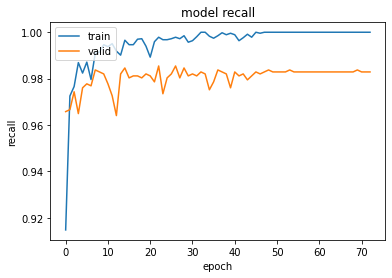

In [ ]:
plt.plot(modelo_final_1_Hist.history['recall'])
plt.plot(modelo_final_1_Hist.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

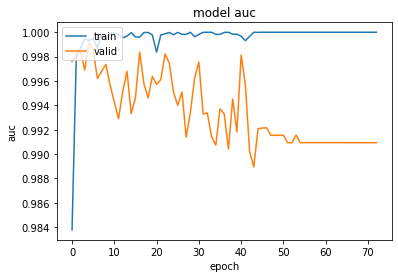

In [ ]:
plt.plot(modelo_final_1_Hist.history['auc'])
plt.plot(modelo_final_1_Hist.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()